In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import nltk
import seaborn

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.corpus import words
from wordcloud import WordCloud
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#sampling
from imblearn.over_sampling import SMOTE 


import warnings
warnings.filterwarnings("ignore")

## Data Collection

#### Steps
 * Select one .sgm file at a time
 * find all the "reuters" tag within the .sgm file
 * iterate over each "reuter" and fetch body, topic and lewissplit tags.
 * Finally, collate all the tags in their respective lists
 * zip the lists into a DataFrame

In [2]:
bodies = []
topics = []
lewissplit  = []

for file in os.listdir("reuters21578/"):
    if file.endswith(".sgm"): 
        filename = os.path.join("reuters21578", file)
        f = open(filename, 'r', encoding='utf-8', errors='ignore')
        dataFile = f.read()
        soup = BeautifulSoup(dataFile, 'html.parser')
        for item in soup.findAll('reuters'): 
            bodies.append(item.find("body"))
            topics.append(item.find("topics"))
            lewissplit.append(item['lewissplit'])

In [3]:
reuters_df=pd.DataFrame(list(zip(bodies,topics,lewissplit)),columns=["articles","topic","lewissplit"])

## Data Overview

In [4]:
reuters_df.head()

,articles,topic,lewissplit
0,[Inco Ltd said it did not expect its\nearlier ...,[],TRAIN
1,"[Mason Benson, former president and\nchief ope...",[],TRAIN
2,[In a discovery that could complicate the\nsea...,[],TRAIN
3,[Doctors at the Centers for Disease\nControl i...,[],TRAIN
4,[U.S. economic data this week could be\nthe ke...,"[[interest], [retail], [ipi]]",TRAIN


In [5]:
reuters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   articles    18583 non-null  object
 1   topic       21000 non-null  object
 2   lewissplit  21000 non-null  object
dtypes: object(3)
memory usage: 492.3+ KB


In [6]:
reuters_df.isna().sum()

articles      2417
topic            0
lewissplit       0
dtype: int64

* There are 3 columnns, each of type object
* There are 21000 rows in the dataset
* There are 2417 null values in the articles. Hence those rows contain no content

In [7]:
#drop the rows having null values
reuters_df.dropna(inplace=True)

In [8]:
## checking shape of the dataset after removing null values
print(f" There are {reuters_df.shape[0]} rows in the dataset")

 There are 18583 rows in the dataset


In [9]:
# converting articles and topic columns to their text format
reuters_df["articles"]=reuters_df["articles"].apply(lambda x: x.text)
reuters_df["topic"]=reuters_df["topic"].apply(lambda x: x.text)

In [10]:
reuters_df["topic"].value_counts(normalize=True)

                                           0.457407
earn                                       0.192918
acq                                        0.111285
crude                                      0.018512
trade                                      0.017704
                                             ...   
goldplatinum                               0.000054
gnpjobsbopcpi                              0.000054
graincornriceoilseedcottonseedgroundnut    0.000054
tradewpicpiincomeretail                    0.000054
tradejobs                                  0.000054
Name: topic, Length: 639, dtype: float64

* About 46% of the news articles do not have any topic assigned to them
* we remove all those rows that do not have any topic assigned to them - there might be many articles related to topic "earn" within those rows. 
* Hence we remove those rows altogether to generalize our model and reduced the ambiguity

In [11]:
# removing rows which do not have any topic 
reuters_df=reuters_df[reuters_df["topic"]!=""]

## Data Cleaning

In [12]:
stop_words=stopwords.words("English")

In [13]:
def clean_articles(row):
    # remove url links
    row = re.sub("http\s+", '', row)
    # remove html tags
    row = re.sub("<[^<]+?>", '', row)
    # remove special characters, numbers and punctuations
    row = re.sub("[^A-za-z+ ]", ' ', row)
    # lower the text
    row = row.lower()
    # remove stopwords and words that have length of 1
    row = " ".join(word for word in nltk.wordpunct_tokenize(row) if len(word)!=1 and word not in stop_words)

    return row

In [14]:
reuters_df["articles"]=reuters_df["articles"].apply(lambda x:clean_articles(x))

## EDA

In [15]:
reuters_df["topic"].value_counts(normalize=True)

earn                                       0.355549
acq                                        0.205098
crude                                      0.034117
trade                                      0.032629
money-fx                                   0.024298
                                             ...   
goldplatinum                               0.000099
gnpjobsbopcpi                              0.000099
graincornriceoilseedcottonseedgroundnut    0.000099
tradewpicpiincomeretail                    0.000099
tradejobs                                  0.000099
Name: topic, Length: 638, dtype: float64

* <b>earn</b> is the most common topic within the articles. It covers about 36% of the articles.
* It is followed by <b>acq</b> and <b>crude</b> which cover about 21% and 3% of the articles respectively

In [16]:
reuters_df_earn=reuters_df[reuters_df["topic"]=="earn"]
reuters_df_others=reuters_df[reuters_df["topic"]!="earn"]

* since, our target is to identify articles that belong to <b>earn</b> category, we segregate our data into earn and others categories

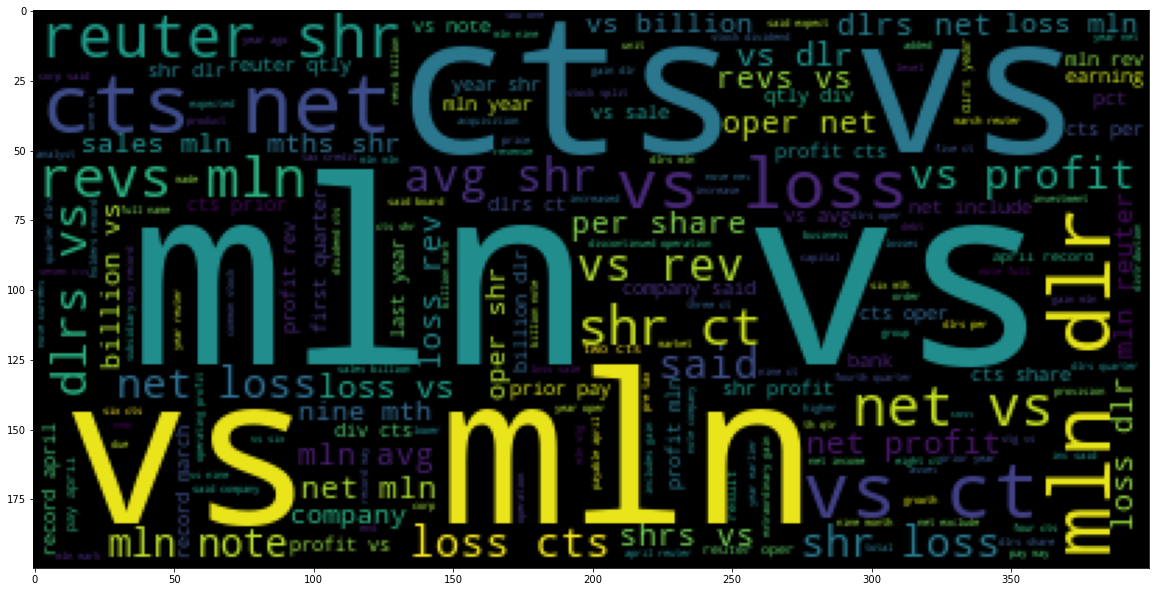

In [17]:
earn_keywords=" ".join(art for art in reuters_df_earn["articles"].tolist())
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(earn_keywords));

* The most common keywords in <b>earn</b> category are "cts","mln","vs", and "net".
* some of the more keywords include "shr","loss","dlr" and "share".

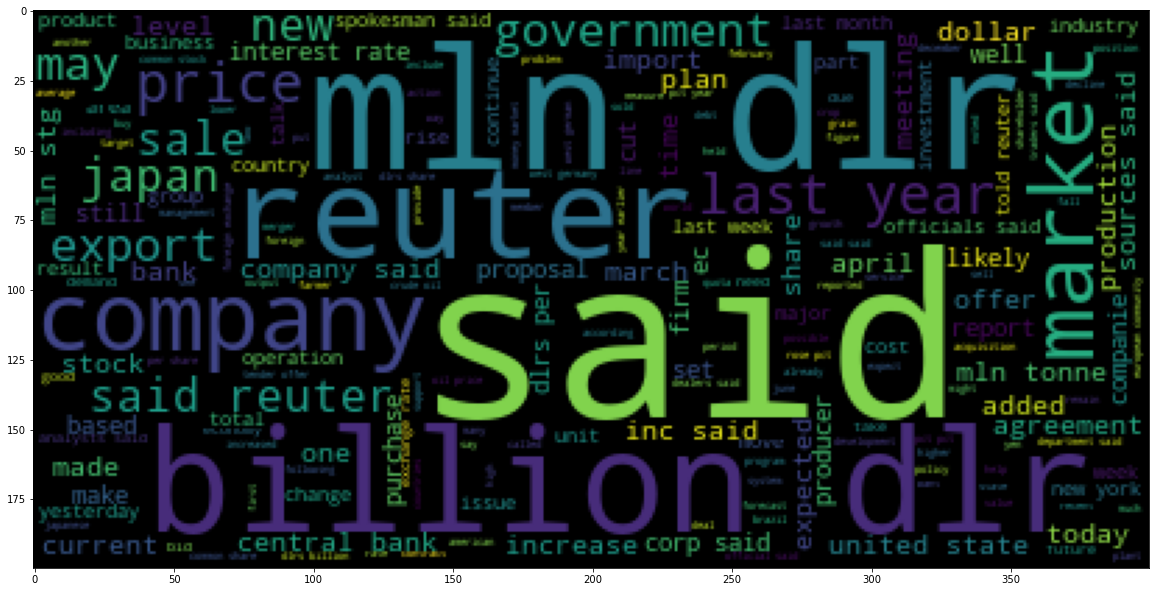

In [18]:
other_keywords=" ".join(art for art in reuters_df_others["articles"].tolist())
plt.figure(figsize=(20,20))
plt.imshow(WordCloud().generate(other_keywords));

* The most common keywords in earn category are "said","pct","billion", and "reuter".
* some of the more keywords include "tonne","offer","company","market" and "dollar".

### Data Transformation

In [19]:
# segregating the data into train and test dataframes
reuters_df_train = reuters_df[reuters_df["lewissplit"]=="TRAIN"]
reuters_df_test  = reuters_df[reuters_df["lewissplit"]=="TEST"]

In [20]:
#initializing the vectorizer.
tfidf = TfidfVectorizer(min_df=5)

In [21]:
# vectorizing train and test datasets
X_train = tfidf.fit_transform(reuters_df_train["articles"].tolist())
X_test  = tfidf.transform(reuters_df_test["articles"].tolist())

In [22]:
# coverting the labels to binary- 1 for earn and 0 for others
y_train = reuters_df_train["topic"].apply(lambda x: 1 if x=="earn" else 0).tolist()
y_test  = reuters_df_test["topic"].apply(lambda x: 1 if x=="earn" else 0).tolist()

In [23]:
print(f"The vectorizer has {X_train.shape[0]} rows and {X_train.shape[1]} features")

The vectorizer has 7068 rows and 6690 features


In [24]:
from collections import Counter

In [25]:
counter=Counter(y_train)
counter

Counter({0: 4395, 1: 2673})

* Here, the data is imbalanced with 4395 rows having 0 and 2673 rows having 1.
* We'll use SMOTE to balance the dataset

In [26]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train,y_train)

In [27]:
counter=Counter(y_train)
counter

Counter({0: 4395, 1: 4395})

* Now the data is perfectly balanced

## Modelling

In [28]:
def make_confusion_matrix(y_actual,y_predict,type_data):
    cm = metrics.confusion_matrix(y_actual, y_predict)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['others', 'earn']
    plt.title(f'Confusion Matrix - {type_data} Data')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i][j]))
    plt.show()
    print(f"\n Classification Matrix for {type_data} data:\n",metrics.classification_report(y_actual, y_predict))

In [29]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)  
    
    train_f1 = metrics.f1_score(y_train,pred_train)
    test_f1 = metrics.f1_score(y_test,pred_test)  
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ", model.score(X_train,y_train))
        print("Accuracy on test set : ",     model.score(X_test,y_test))
        print("\nRecall on training set : ", metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",       metrics.recall_score(y_test,pred_test))
        print("\nPrecision on training set : ", metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",     metrics.precision_score(y_test,pred_test))
        print("\nF1 score on training set : ", metrics.f1_score(y_train,pred_train))
        print("F1 score on test set : ",     metrics.f1_score(y_test,pred_test))
        
    
    return score_list # returning the list with train and test scores

### Logistic Regression

In [30]:
logr_model=LogisticRegression(random_state=42)
logr_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [31]:
logr_score= get_metrics_score(logr_model)

Accuracy on training set :  0.9863481228668942
Accuracy on test set :  0.9885760913912689

Recall on training set :  0.9777019340159272
Recall on test set :  0.9797979797979798

Precision on training set :  0.9949062282935864
Precision on test set :  0.9886749716874292

F1 score on training set :  0.9862290566903833
F1 score on test set :  0.9842164599774521


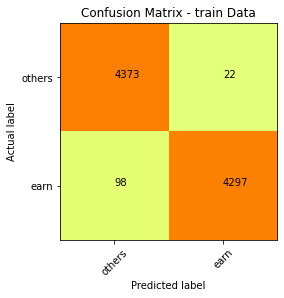


 Classification Matrix for train data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4395
           1       0.99      0.98      0.99      4395

    accuracy                           0.99      8790
   macro avg       0.99      0.99      0.99      8790
weighted avg       0.99      0.99      0.99      8790



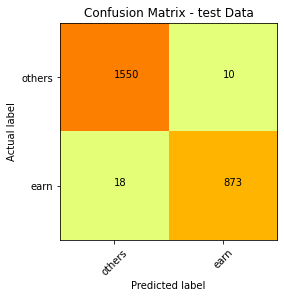


 Classification Matrix for test data:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1560
           1       0.99      0.98      0.98       891

    accuracy                           0.99      2451
   macro avg       0.99      0.99      0.99      2451
weighted avg       0.99      0.99      0.99      2451



In [32]:
y_pred_train=logr_model.predict(X_train)
y_pred_test=logr_model.predict(X_test)
## training data
make_confusion_matrix(y_train,y_pred_train,"train")
## training data
make_confusion_matrix(y_test,y_pred_test,"test")

### Linear SVC

In [33]:
svc_model = LinearSVC(random_state=42)
svc_model.fit(X_train, y_train)

LinearSVC(random_state=42)

In [34]:
# metrics
svc_score=get_metrics_score(svc_model)

Accuracy on training set :  0.9993174061433447
Accuracy on test set :  0.988984088127295

Recall on training set :  1.0
Recall on test set :  0.9854096520763187

Precision on training set :  0.9986366734832992
Precision on test set :  0.984304932735426

F1 score on training set :  0.9993178717598908
F1 score on test set :  0.9848569826135727


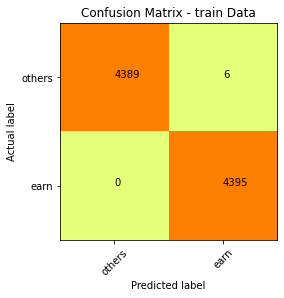


 Classification Matrix for train data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4395
           1       1.00      1.00      1.00      4395

    accuracy                           1.00      8790
   macro avg       1.00      1.00      1.00      8790
weighted avg       1.00      1.00      1.00      8790



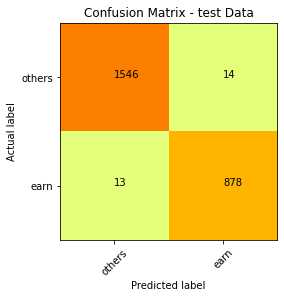


 Classification Matrix for test data:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1560
           1       0.98      0.99      0.98       891

    accuracy                           0.99      2451
   macro avg       0.99      0.99      0.99      2451
weighted avg       0.99      0.99      0.99      2451



In [35]:
y_pred_train=svc_model.predict(X_train)
y_pred_test=svc_model.predict(X_test)
## training data
make_confusion_matrix(y_train,y_pred_train,"train")
## training data
make_confusion_matrix(y_test,y_pred_test,"test")

### Comparison

In [36]:
# defining list of models
models = [logr_model,svc_model]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))
    f1_train.append(np.round(j[6],2))
    f1_test.append(np.round(j[7],2))

In [37]:
comparison_frame = pd.DataFrame({'Model':['Logisitic Regression','Linear SVC'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test,
                                          'Train_F1':f1_train,'Test_F1':f1_test}) 
comparison_frame

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
0,Logisitic Regression,0.99,0.99,0.98,0.98,0.99,0.99,0.99,0.98
1,Linear SVC,1.00,0.99,1.00,0.99,1.00,0.98,1.00,0.98


##### Comparison

* Both the models have performed extremely well. Hence, we would not evaluate the data on any other model
* Linear SVC has a little edge over Logistic Regression	. Linear SVC can just slightly better predict the articles belonging to earn as compared to  Logistic Regression. 
* Hence, We can choose Linear SVC as our final model

### Evaluation

In [38]:
def read_data(filename):
    bodies = []
    f = open(filename, 'r', encoding='utf-8', errors='ignore')
    dataFile = f.read()
    soup = BeautifulSoup(dataFile, 'html.parser')
    for item in soup.findAll('reuters'): 
        bodies.append(item.find("body"))
    test_df=pd.DataFrame(bodies,columns=["articles"])
    return test_df

In [39]:
def treat_test_data(data,form):
    if form =="file":
        test_df=read_data(data)
        test_df=test_df.dropna()
        test_df["articles"]=test_df["articles"].apply(lambda x: x.text)
        test_df["articles"]=test_df["articles"].apply(lambda x: clean_articles(x))
        test_data = tfidf.transform(test_df["articles"].tolist())
        result=svc_model.predict(test_data)
        result=["earn" if r==1 else "others" for r in result]
        test_df["prediction"]=result
        return test_df
    else:
        clean_data=clean_articles(data)
        test_data = tfidf.transform([clean_data])
        result=svc_model.predict(test_data)
        result=["earn" if r==1 else "others" for r in result]
        return result

In [40]:
treat_test_data("reuters21578/reut2-020.sgm","file")

,articles,prediction
0,dollar goes way wall street japanese finally m...,others
1,nec corp supply mhs france manufacturing techn...,others
2,finance ministry take wait see stance tokyo st...,others
3,outlook mexico economy stockmarket remains opt...,others
4,asian cocoa producers expanding output despite...,others
...,...,...
992,qtly div one cent vs cts prior quarter payable...,earn
993,american telephone telegraph co said supported...,others
997,afg industries inc said board authorized manag...,others
998,morgan co inc said third quarter net income ro...,earn


In [41]:
input_text="champion products inc said board directors approved two one stock split common shares shareholders record april company also said board voted recommend shareholders annual meeting april increase authorized capital stock five mln mln shares reuter"
treat_test_data(input_text,"raw")

['earn']